# Notes to myself & flags

In [ ]:
ssps_list = ['ssp1','ssp2','ssp3','ssp4','ssp5']


TODO
* LULC 2000 instead of 2015 please !
* Lat/Lon are rounded up :(

Big assumptions to flag
 * Assuming soil quality doesn't change (really bc no data on that)
 * - Is it not a terrible assumption to assume all 5min (10km) cropland pixel is cultivated? YES
  - Calculated %Cropland crop_mask
  - Else go back to Monfreda and find use %area cultivated for each cell, then mutliply this by yield
  - And calc F['%cultivated'] = ... (aggregate crops again...)
  - see where I export future_df

# Imports

In [6]:
import pickle

import os
from collections import OrderedDict

import hazelbean as hb
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import seaborn as sns

import math
from scipy import stats

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics

import xgboost as xgb

import gdal
import pygeoprocessing
# import taskgraph
import netCDF4

In [4]:
## I can't install logging :'(
## Command "python setup.py egg_info" failed with error code 1 in /private/var/folders/zz/mdt_32ps1ydd2xls85z7qt240000gp/T/pip-install-gr4qw335/logging/

import logging as L
L.basicConfig(level=logging.DEBUG)
LOGGER = L.getLogger(__name__)

NameError: name 'logging' is not defined

# Pre-processing

## Caloric yields maps preparation

### Make relevant crop list

In [ ]:
## Merge BCK's CSVs
sustenance = pd.read_csv('../Data/inputs/Crop/crop_table_BCK.csv')
crop_caloric_contents = pd.read_csv('../Data/inputs/Crop/crop_nutrient.csv',sep=';')
crop_caloric_contents = crop_caloric_contents.merge(sustenance, how='left',
                                                    right_on='file_name',
                                                   left_on='filenm')
crop_caloric_contents.to_csv('../Data/inputs/Crop/crop_nutrient_contents.csv')

In [5]:
crop_caloric_contents = pd.read_csv('../Data/inputs/Crop/crop_nutrient_contents.csv')
crop_caloric_contents = crop_caloric_contents.set_index('filenm')

crops_list = []
for cropnm in crop_caloric_contents.index:
    if crop_caloric_contents['nutritional_relevance'][cropnm] == 1:
        crops_list.append(cropnm)

### Make Caloric Production rasters + Aggregate (all crops)

Percent refuse:
    It is the percent of the raw yield that is discarded from the yield raster. You need to account for this before calculating calories, otherwise you're including nut shells and corn husks and such.

In [219]:
from raster_calc_utils import *
from spatial_utils import *

In [51]:
caloric_production_path_list = []
crop_HarvestedAreaHectares_path_list = []

Crop_dir = '../Data/inputs/Crop'
Earthstat_dir = '../Data/inputs/Crop/Earthstat/HarvestedAreaYield175Crops_Geotiff'
ha_per_cell_5min_path = '../Data/inputs/Base/ha_per_cell_5m.tif'

Earthstat_intermediate_dir = '../Data/inputs/Crop/Earthstat_Preprocessed'


## Recalculate ha_per_cell at 5min
y_ha_column = None 

for cropnm in crops_list:
    crop_YieldPerHectare_path = os.path.join(Earthstat_dir,cropnm+'_HarvAreaYield_Geotiff/'+cropnm+'_YieldPerHectare.tif')
    crop_HarvestedAreaHectares_path = os.path.join(Earthstat_dir,cropnm+'_HarvAreaYield_Geotiff/'+cropnm+'_HarvestedAreaHectares.tif')
    crop_Production_path = os.path.join(Earthstat_dir,cropnm+'_HarvAreaYield_Geotiff/'+cropnm+'_Production.tif')
    
    crop_HarvestedAreaHectares_raster_info = pygeoprocessing.get_raster_info(
            crop_HarvestedAreaHectares_path)
    crop_HarvestedAreaHectares_nodata = crop_HarvestedAreaHectares_raster_info['nodata'][0]
    if crop_HarvestedAreaHectares_nodata == None:
        crop_HarvestedAreaHectares_nodata = -999
    crop_HarvestedAreaHectares_path_list.append(crop_HarvestedAreaHectares_path)
        
    crop_Production_raster_info = pygeoprocessing.get_raster_info(
            crop_Production_path)
    crop_Production_nodata = crop_Production_raster_info['nodata'][0]
    if crop_Production_nodata == None:
        crop_Production_nodata = -999
    
    if y_ha_column is None:
        y_lat_array = np.linspace(
                crop_HarvestedAreaHectares_raster_info['geotransform'][3],
                crop_HarvestedAreaHectares_raster_info['geotransform'][3] +
                crop_HarvestedAreaHectares_raster_info['geotransform'][5] *
                crop_HarvestedAreaHectares_raster_info['raster_size'][1],
                crop_HarvestedAreaHectares_raster_info['raster_size'][1])
        y_ha_array = area_of_pixel(
                abs(crop_HarvestedAreaHectares_raster_info['geotransform'][1]),
                y_lat_array) / 10000.0
        y_ha_column = y_ha_array.reshape((y_ha_array.size, 1))

    ## Skip this because I have Prods rasters - was just to compare !
    ## 1) Make raster Crop Production Yield from Earthstats rasters:
    ## Crop_Production [tons] = Crop_YieldPerHectare[tons/ha] * ha_per_cell_5min * Crop_HarvestedAreaFraction
    ## But not needed - I have Prods rasters- was just to compare !
    
    '''
    !!!! HAVENT RUN SUCCESSFULLY. DOESN'T RETURN ACTUAL ERROR ONLY TASKGRAPH ERROR

    crop_production_path = os.path.join(
        Earthstat_intermediate_dir,'Productions','%s_Production.tif' % cropnm)
    
    crop_production_nodata = -1.0
    crop_production_task = task_graph.add_task(
            func=pygeoprocessing.raster_calculator,
            args=(
                #base_raster_path_band_const_list =
                    [(crop_YieldPerHectare_path, 1),
                     (crop_HarvestedAreaHectares_path, 1),
                     y_ha_column,
                     (crop_HarvestedAreaHectares_nodata, 'raw'),
                     (crop_production_nodata, 'raw')],
                crop_production_op,     #local_op
                crop_production_path,   #target_raster_path
                gdal.GDT_Float32,       #datatype_target 
                crop_production_nodata  #nodata_target
                ),
            target_path_list=[crop_production_path],
            task_name=('Calc Crop Production Raster for '+ cropnm))
    '''  

    ## 2) Convert to Caloric Production with crop_nutrient_contents table:
    ## Crop_Caloric_Production [cal] = Crop_Production [tons] * Crop_Energy[kJ/100g from crop_nutrient table] * 1e4[100g/tons] * 239,006[cal/kJ]
    #print('Making '+cropnm+' Caloric Production raster')
        
        
    caloric_production_path = os.path.join(
        Earthstat_intermediate_dir,'Productions','%s_Caloric_Production.tif' % cropnm) 
    caloric_production_path_list.append(caloric_production_path)
    
    remove_nut_shells_etc = (100-crop_caloric_contents['Percent refuse'][cropnm])/100
    crop_energy = crop_caloric_contents['Energy'][cropnm] * remove_nut_shells_etc * 2390060 
    
    crop_prod_array = (crop_Production_path,1)
    cal_per_ton = (crop_energy,'raw')
    nodata = (crop_Production_nodata, 'raw')
    
    pygeoprocessing.raster_calculator(
        base_raster_path_band_const_list = [crop_prod_array,cal_per_ton,nodata],
        local_op = convert_production_tons_to_caloric,
        target_raster_path = caloric_production_path,
        datatype_target = gdal.GDT_Float32,
        nodata_target = crop_Production_nodata)
 

In [52]:
# Aggregation

# Total caloric production (sum caloric_Productions)

Total_Caloric_Production_path = os.path.join(
    Earthstat_intermediate_dir, 'Total_caloric_production.tif')

pygeoprocessing.raster_calculator(
    base_raster_path_band_const_list =
        [(crop_Production_nodata, 'raw')] +
        [(path, 1) for path in caloric_production_path_list],
    local_op = sum_arrays_op,
    target_raster_path = Total_Caloric_Production_path,
    datatype_target = gdal.GDT_Float32,
    nodata_target = crop_Production_nodata)

# Total harvested areas (ha) (by summing harvested hectares)

Total_harvested_area_ha_raster_path = os.path.join(
    Earthstat_intermediate_dir, 'Total_harvested_area_ha.tif')

pygeoprocessing.raster_calculator(
    base_raster_path_band_const_list =
        [(crop_HarvestedAreaHectares_nodata, 'raw')] +
        [(path, 1) for path in crop_HarvestedAreaHectares_path_list],
    local_op = sum_arrays_op,
    target_raster_path = Total_harvested_area_ha_raster_path,
    datatype_target = gdal.GDT_Float32,
    nodata_target = crop_HarvestedAreaHectares_nodata)

# Aggregated caloric yield = [total caloric production/Total harvested areas(ha)]

agg_calories_yield_raster_path = os.path.join(
    Earthstat_intermediate_dir, 'agg_Caloric_yield_per_ha.tif')

pygeoprocessing.raster_calculator(
    base_raster_path_band_const_list =
        [(Total_Caloric_Production_path, 1),
         (Total_harvested_area_ha_raster_path, 1),
         (crop_HarvestedAreaHectares_nodata, 'raw')],
    local_op = div_arrays_op,
    target_raster_path = agg_calories_yield_raster_path,
    datatype_target = gdal.GDT_Float32,
    nodata_target = crop_Production_nodata)

### TO FIX : Utils that I actually can't export because numpy doesn't work in utils.py?!

In [19]:
def convert_production_tons_to_caloric(crop_prod_array, calories_per_ton, nodata):
    """Calorie (i) production = Crop (i) production x KJ content of crop (i).

    Parameters:
        crop_prod_array (array): production in tons.
        calories_per_ton (float): calories/ton accounting for % refuse
            of the crop.
        nodata (float): nodata value for `crop_prod_array` and result.

    Returns:
        calorie production production * calories / ton

    """
    result = np.array(crop_prod_array)
    result[~np.isclose(crop_prod_array, nodata)] *= calories_per_ton
    return result

def div_arrays_op(numerator_array, denominator_array, nodata):
    """Calculate calorie yield.

    Parameters:
        numerator
        e.g total_calorie_array (np.ndarray): total calories per element
        denominator
        e.g harvested_area_ha_array (np.ndarray): amount of total harvested
            area in hectares per eleent.
        nodata (float): the nodata value for all inputs and result.

    Returns:
        divided
        e.g calorie yield = total calorie production / sum(harvested area)

    """
    result = np.empty_like(numerator_array)
    result[:] = nodata
    zero_mask = (denominator_array == 0.0)
    valid_mask = (
        ~np.isclose(numerator_array, nodata) &
        ~np.isclose(denominator_array, nodata)) & ~zero_mask
    result[valid_mask] = (
        numerator_array[valid_mask] / (
            denominator_array[valid_mask]))
    result[zero_mask] = 0.0
    return result




def crop_production_op(
        yield_array, prop_harvest_area, cell_area_ha,
        prop_harvest_area_nodata, target_nodata):
    """Calculate crop production

    Parameters:
        yield_array (np.ndarray): yield of crop in Tons/Ha
        prop_harevest_area (np.ndarray): proportional harvested area of
            the crop per cell.
        cell_harea_ha (np.ndarray): area of the cell in Ha.
        prop_harvest_area_nodata (float): nodata value for prop_harevest_area
        target_nodata (float): nodata value for result

    Returns:
        Crop production =
            Yield(i) x harvested area (proportion) (i) * area of cell.

    """
    crop_production = np.empty_like(yield_array, dtype=np.float32)
    crop_production[:] = target_nodata
    valid_mask = ~np.isclose(prop_harvest_area, prop_harvest_area_nodata)
    crop_production[valid_mask] = (
        yield_array[valid_mask] * prop_harvest_area[valid_mask] *
        cell_area_ha[valid_mask])
    return crop_production

def mult_arrays_op(nodata, *array_list):
    """Multiply array stack and ignore nodata."""
    result = np.ones(array_list[0].shape, dtype=np.float32)
    valid_mask = np.empty(result.shape, dtype=np.bool)
    valid_mask[:] = False
    for array in array_list:
        local_valid_mask = ~np.isclose(array, nodata)
        valid_mask |= local_valid_mask
    for array in array_list:
        result[valid_mask] *= array[valid_mask]
    result[~valid_mask] = nodata
    return result


def sum_arrays_op(nodata, *array_list):
    """Sum all rasters assuming they all have the same nodata value."""
    result = np.zeros(array_list[0].shape, dtype=np.float32)
    valid_mask = np.empty(result.shape, dtype=np.bool)
    valid_mask[:] = False
    for array in array_list:
        local_valid_mask = ~np.isclose(array, nodata)
        valid_mask |= local_valid_mask
        result[local_valid_mask] += array[local_valid_mask]
    result[~valid_mask] = nodata
    return result

def calories_yield_op(total_calorie_array, harvested_area_ha_array, nodata):
    """Calculate calorie yield.

    Parameters:
        total_calorie_array (np.ndarray): total calories per element
        harvested_area_ha_array (np.ndarray): amount of total harvested
            area in hectares per eleent.
        nodata (float): the nodata value for all inputs and result.

    Returns:
        calorie yield = total calorie production / sum(harvested area)

    """
    result = np.empty_like(total_calorie_array)
    result[:] = nodata
    zero_mask = (harvested_area_ha_array == 0.0)
    valid_mask = (
        ~np.isclose(total_calorie_array, nodata) &
        ~np.isclose(harvested_area_ha_array, nodata)) & ~zero_mask
    result[valid_mask] = (
        total_calorie_array[valid_mask] / (
            harvested_area_ha_array[valid_mask]))
    result[zero_mask] = 0.0
    return result

def area_of_pixel(pixel_size, center_lat):
    """Calculate m^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in m^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1-(b/a)**2)
    area_list = []
    for f in [center_lat+pixel_size/2, center_lat-pixel_size/2]:
        zm = 1 - e*np.sin(np.radians(f))
        zp = 1 + e*np.sin(np.radians(f))
        area_list.append(
            np.pi * b**2 * (
                np.log(zp/zm) / (2*e) +
                np.sin(np.radians(f)) / (zp*zm)))
    return pixel_size / 360. * (area_list[0]-area_list[1])

### Aggregate by crop types (to do)

In [39]:
# Total harvested areas (ha) per crop_type

for crop_type in crop_types_list:
    
    Total_harvested_area_ha_raster_path = os.path.join(
            Earthstat_intermediate_dir, crop_type+'_harvested_area_ha.tif')
        
    for cropnm in crops_list:
        crop_HarvestedAreaHectares_path = os.path.join(Earthstat_dir,cropnm+'_HarvAreaYield_Geotiff/'+cropnm+'_HarvestedAreaHectares.tif')
        crop_HarvestedAreaHectares_raster_info = pygeoprocessing.get_raster_info(
                crop_HarvestedAreaHectares_path)
        crop_HarvestedAreaHectares_nodata = crop_HarvestedAreaHectares_raster_info['nodata'][0]
        if crop_HarvestedAreaHectares_nodata == None:
            crop_HarvestedAreaHectares_nodata = 0

        if cropnm in crop_membership[crop_type]:

            pygeoprocessing.raster_calculator(
            base_raster_path_band_const_list =
                [(crop_HarvestedAreaHectares_nodata, 'raw'),
                 (crop_HarvestedAreaHectares_path, 1)],
            local_op = sum_arrays_op,
            target_raster_path = Total_harvested_area_ha_raster_path,
            datatype_target = gdal.GDT_Float32,
            nodata_target = crop_HarvestedAreaHectares_nodata)

#### Crop types list

In [212]:
crop_types_list = ['c3ann','c3per','c4ann','c4per','c3nfx'] # = crop_membership.keys()

crop_membership = OrderedDict()
crop_membership['c3ann'] = [
        'aniseetc',
        'artichoke',
        'asparagus',
        'bambara',
        'barley',
        'buckwheat',
        'cabbage',
        'canaryseed',
        'carob',
        'carrot',
        'cassava',
        'cauliflower',
        'cerealnes',
        'chestnut',
        'cinnamon',
        'cucumberetc',
        'currant',
        'date',
        'eggplant',
        'fonio',
        'garlic',
        'ginger',
        'mixedgrain',
        'hazelnut',
        'hempseed',
        'hop',
        'kapokseed',
        'linseed',
        'mango',
        'mate',
        'mustard',
        'nutmeg',
        'okra',
        'onion',
        'greenonion',
        'peppermint',
        'potato',
        'pumpkinetc',
        'pyrethrum',
        'ramie',
        'rapeseed',
        'rice',
        'safflower',
        'sisal',
        'sorghumfor',
        'sourcherry',
        'spinach',
        'sugarbeet',
        'sunflower',
        'taro',
        'tobacco',
        'tomato',
        'triticale',
        'tung',
        'vanilla',
        'vetch',
        'walnut',
        'watermelon',
        'wheat',
        'yam',
        'yautia']

crop_membership['c3per'] = [
        'almond',
        'apple',
        'apricot',
        'areca',
        'avocado',
        'banana',
        'blueberry',
        'brazil',
        'cashewapple',
        'cashew',
        'cherry',
        'chicory',
        'chilleetc',
        'citrusnes',
        'clove',
        'cocoa',
        'coconut',
        'coffee',
        'cotton',
        'cranberry',
        'fig',
        'flax',
        'grapefruitetc',
        'grape',
        'jute',
        'karite',
        'kiwi',
        'kolanut',
        'lemonlime',
        'lettuce',
        'abaca',
        'melonetc',
        'melonseed',
        'oats',
        'oilpalm',
        'oilseedfor',
        'olive',
        'orange',
        'papaya',
        'peachetc',
        'pear',
        'pepper',
        'persimmon',
        'pineapple',
        'pistachio',
        'plantain',
        'plum',
        'poppy',
        'quince',
        'quinoa',
        'rasberry',
        'rubber',
        'rye',
        'stonefruitnes',
        'strawberry',
        'stringbean',
        'sweetpotato',
        'tangetc',
        'tea',
    ]

crop_membership['c4ann'] = [
        'maize',
        'millet',
        'sorghum',
    ]

crop_membership['c4per'] = [
        'greencorn',
        'sugarcane',

    ]

crop_membership['c3nfx'] = [
        'bean',
        'greenbean',
        'soybean',
        'chickpea',
        'clover',
        'cowpea',
        'groundnut',
        'lupin',
        'pea',
        'greenpea',
        'pigeonpea',
        'lentil',
        'legumenes',
        'broadbean',
        'castor',

    ]

## Fertilizers

Nitrogen	Fertilizer:	(units	kg	N/ha/crop	season;	(per	year	for	single	cropping))
* fertl_c3ann: N. fertilizer rate for C3 annual crops
* fertl_c4ann: N. fertilizer rate for C4 annual crops
* fertl_c3per: N. fertilizer rate for C3 perennial crops
* fertl_c4per: N. fertilizer rate for C4 perennial crops
* fertl_c3nfx: N. fertilizer rate for C3 N-fixing crops

In management_ssp.nc data:
* Year = Band number + 2014 (2015: t=0, band=1) --> 2050 is band 36


In management_historical.nc data:
* Year = Band number + 849 (850: t=0, band=1) --> 2000 is band 1151


### Utils

In [1]:
ssps_list = ['ssp1','ssp2','ssp3','ssp4','ssp5']

In [3]:
def netcdf_to_geotiff(base_raster_path,target_raster_path,
                      band_num=1):
    '''
    base_raster_path should be in format : r'NETCDF:"path:dimension_name' 
    '''
    
    gtiff_driver = gdal.GetDriverByName('GTiff')

    raster = gdal.OpenEx(base_raster_path, gdal.OF_RASTER)

    target_raster = gtiff_driver.CreateCopy(target_raster_path, raster)
    target_band = target_raster.GetRasterBand(band_num)
    target_band.XSize
    target_band.FlushCache()
    target_array = target_band.ReadAsArray()

    target_band = None
    target_raster = None

### NetCDF to Geotiffs

In [ ]:
# SSPs data 

for crop_type_raster in ['fertl_c3ann','fertl_c3per','fertl_c3nfx',
               'fertl_c4ann','fertl_c4per']:
    
    for ssp in ssps_list:
        base_raster_path = r'NETCDF:"../Data/inputs/Management/Fertilizers/management_'+ssp+'.nc":'+crop_type_raster
        target_raster_path = '../Data/inputs/Management/Fertilizers/'+ssp+'/'+crop_type_raster+'.tif'
        netcdf_to_geotiff(base_raster_path,target_raster_path,
                      band_num=36) # Band number = 36 for year 2050

In [ ]:
# 2000 data

for crop_type_raster in ['fertl_c3ann','fertl_c3per','fertl_c3nfx',
               'fertl_c4ann','fertl_c4per']:
    
    base_raster_path = r'NETCDF:"../Data/inputs/Management/Fertilizers/management_historical.nc":'+crop_type_raster
    target_raster_path = '../Data/inputs/Management/Fertilizers/2000/'+crop_type_raster+'.tif'

    netcdf_to_geotiff(base_raster_path,target_raster_path,
                      band_num=1151) # Band number = 1151 for year 2000

### Multi-bands Geotiffs to single band (of interest)

In [280]:
# 2000 data

for crop_type_raster in ['fertl_c3ann','fertl_c3per','fertl_c3nfx',
               'fertl_c4ann','fertl_c4per']:
    raster_tif_path = '../Data/inputs/Management/Fertilizers/2000/'+crop_type_raster+'.tif'
    band_num = 1151 ## Year 2000
    target_path = "../Data/inputs/Management/Fertilizers/2000/%s_%d.tif" % (crop_type_raster, band_num)
    
    extract_band((raster_tif_path, band_num), target_path)

    
    

1166
1166
1166
1166
1166


In [281]:
"""Example script of how to extract a raster band to a single raster."""
from osgeo import gdal

import pygeoprocessing


def extract_band(
        base_raster_path_band, target_geotiff_raster_path):
    """Extract a single band to a single band raster.

    Parameters:
        base_raster_path_band (tuple): a (path, band_id) tuple indicating
            which band to extract.
        target_geotiff_raster_path (string): path to target raster (will be
            a GeoTiff).
        driver_name (string): optional, name of the target raster driver,
            defaults to GTiff.

    Returns:
        None.

    """
    base_raster_info = pygeoprocessing.get_raster_info(
        base_raster_path_band[0])
    #print(len(base_raster_info['nodata']))
    pygeoprocessing.new_raster_from_base(
        base_raster_path_band[0], target_geotiff_raster_path,
        base_raster_info['datatype'],
        [base_raster_info['nodata'][base_raster_path_band[1]-1]])

    target_raster = gdal.OpenEx(
        target_geotiff_raster_path, gdal.OF_RASTER | gdal.GA_Update)
    target_band = target_raster.GetRasterBand(1)
    for offset_dict, block_array in pygeoprocessing.iterblocks(
            base_raster_path_band[0], [base_raster_path_band[1]]):
        target_band.WriteArray(
            block_array, xoff=offset_dict['xoff'], yoff=offset_dict['yoff'])

    target_band.FlushCache()
    target_band = None
    target_raster = None


### Resampled (see section resampling)

### Aggregate fertilizers 

In [213]:
crop_types_list

['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx']

Croptype_harvestedarea should already account for number of seasons. You'll see some grid cells for some crops are > 1. That's because the area is already multiplied by the number of seasons


LUH Inputs:
for crop type in ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx']: 
Croptype_applicationrate [kg N/ha/crop season] for crop type in ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx']

To aggregate:
* Total application of fertilizers annually = 
Sum for each crop type:
Croptype_applicationrate * Croptype_HarvestedArea 
*  Aggregated application rate [kg N/ha] =
Total application of fertilizers annually / Total_HarvestedArea


In [287]:
## For 2000

# Total application of fertilizers for each crop type
for crop_type in crop_types_list:
    croptype_harvested_area_ha_raster_path = os.path.join(
            Earthstat_intermediate_dir, crop_type+'_harvested_area_ha.tif')
    fertilizer_rate_path = os.path.join(
            '../Data/inputs/Management/Fertilizers/2000','fertl_'+crop_type+'__5m.tif')
    
    fertl_tot_application_kgN_path = os.path.join(
            '../Data/inputs/Management/Fertilizers/2000/Tot_Application_kgN','fertl_application'+crop_type+'_kgN.tif')
    
    #NoDataValue
    fertl_raster_info = pygeoprocessing.get_raster_info(fertilizer_rate_path)
    fertl_ndv = fertl_raster_info['nodata'][0]
    #if fertl_ndv == None:
    #    fertl_ndv = -999
        
    # Raster calculator
    #(croptype_harvested_area_ha_raster_path,1) * (fertilizer_rate_path,1151)
    
    pygeoprocessing.raster_calculator(
        base_raster_path_band_const_list = [(fertl_ndv, 'raw'),
                                            (croptype_harvested_area_ha_raster_path,1),
                                            (fertilizer_rate_path,1)],
        local_op = mult_arrays_op,
        target_raster_path = fertl_tot_application_kgN_path,
        datatype_target = gdal.GDT_Float32,
        nodata_target = fertl_ndv)
    

In [293]:
[(path,1) for path in os.listdir('../Data/inputs/Management/Fertilizers/2000/Tot_Application_kgN')]

[('fertl_applicationc4per_kgN.tif', 1),
 ('fertl_applicationc3per_kgN.tif', 1),
 ('fertl_applicationc4ann_kgN.tif', 1),
 ('fertl_applicationc3nfx_kgN.tif', 1),
 ('fertl_applicationc3ann_kgN.tif', 1)]

In [294]:
# Total application of fertilizers
# Sum fertl_tot_application_kgN_path for all crop_types
Total_fertl_application_kgN_path = os.path.join('../Data/inputs/Management/Fertilizers/2000/Tot_Application_kgN',
                                              'Total_fertl_application_kgN.tif')

pygeoprocessing.raster_calculator(
        base_raster_path_band_const_list = [(fertl_ndv, 'raw')] +
                        [(path,1) for path in os.listdir('../Data/inputs/Management/Fertilizers/2000/Tot_Application_kgN')],
        local_op = sum_arrays_op,
        target_raster_path = Total_fertl_application_kgN_path,
        datatype_target = gdal.GDT_Float32,
        nodata_target = fertl_ndv)

ValueError: The following files were expected but do not exist on the filesystem: ['fertl_applicationc4per_kgN.tif', 'fertl_applicationc3per_kgN.tif', 'fertl_applicationc4ann_kgN.tif', 'fertl_applicationc3nfx_kgN.tif', 'fertl_applicationc3ann_kgN.tif']

In [ ]:
# Total HarvestedArea
tot_harvested_area_path = os.path.join(Earthstat_intermediate_dir,'Total_harvested_area_ha.tif')

# Aggregated application rate [kg N/ha] 
Agg_fertilizers_rate_path = os.path.join('../Data/inputs/Management/Fertilizers/2000',
                                              'Agg_fertl_rate.tif')


pygeoprocessing.raster_calculator(
        base_raster_path_band_const_list = [(Total_fertl_application_kgN_path,1),
                                            (tot_harvested_area_path,1),
                                            (fertl_ndv, 'raw')]
        local_op = div_arrays_op,
        target_raster_path = Agg_fertilizers_rate_path,
        datatype_target = gdal.GDT_Float32,
        nodata_target = fertl_ndv)

# Resample to 5min

In [282]:
match_raster = '../Data/inputs/Base/country_ids.tif'

## Resample fertilizers

In [283]:
for filename in os.listdir('../Data/inputs/Management/Fertilizers/2000'):
    if filename.endswith("_1151.tif"):  
        input_raster = os.path.join('../Data/inputs/Management/Fertilizers/2000',filename)
        output_raster = os.path.join('../Data/inputs/Management/Fertilizers/2000',filename[:-8]+'_5m.tif')
        print('Resampling fertl '+filename+' to 5 arcmin')
        
        #resample_raster(input_raster, match_raster, output_raster,band_num=1151)

        hb.spatial_utils.align_dataset_to_match(input_raster,
                                        match_raster,
                                        output_raster,
                                        resample_method='bilinear',
                                        output_data_type=7)

Resampling fertl fertl_c3ann_1151.tif to 5 arcmin
Resampling fertl fertl_c4per_1151.tif to 5 arcmin
Resampling fertl fertl_c3nfx_1151.tif to 5 arcmin
Resampling fertl fertl_c3per_1151.tif to 5 arcmin
Resampling fertl fertl_c4ann_1151.tif to 5 arcmin


## Resample to %Cropland

In [8]:
def make_cropland_mask(input_raster, output_raster):
    file = gdal.Open(input_raster)
    band = file.GetRasterBand(1)
    band.SetNoDataValue(-999) #tentative
    raster = band.ReadAsArray()

    # Reclassification
    raster[raster != 2] = 0
    raster[raster == 2 ] = 1

    # Create new file
    file2 = gdal.GetDriverByName('GTiff').Create(output_raster, file.RasterXSize , file.RasterYSize , 1)
    file2.GetRasterBand(1).WriteArray(raster)
    file2.GetRasterBand(1).SetNoDataValue(-999) #tentative
    file2.SetProjection(file.GetProjection())
    file2.SetGeoTransform(file.GetGeoTransform())
    file2.FlushCache()

In [ ]:
## Resample LUs to Cropland masks

for filename in os.listdir('../Data/inputs/LU/SEALS_Oct18(300m)'):
    if filename.endswith(".tif"):  
        input_raster = os.path.join('../Data/inputs/LU/SEALS_Oct18(300m)', filename)
        intermediate_raster = ('../Data/inputs/LU/SEALS_Oct18_CropMask_300m/Cropmask_'+filename)
        output_raster = ('../Data/inputs/LU/SEALS_Oct18_CropMask_5m/Cropmask_'+filename)
        
        print('Making Cropland Mask for '+filename)
        make_cropland_mask(input_raster, intermediate_raster)
        
        print('Resampling Cropland Mask of '+filename+' to 5 arcmin')
        hb.spatial_utils.align_dataset_to_match(intermediate_raster,
                                        match_raster,
                                        output_raster,
                                        resample_method='average',
                                        output_data_type=7)

In [9]:
## (Same as above for new rasters)
filename = 'lulc_esa_2000_reclassified_to_seals_simplified.tif'

input_raster = os.path.join('../Data/inputs/LU/SEALS_Oct18(300m)', filename)
intermediate_raster = ('../Data/inputs/LU/SEALS_Oct18_CropMask_300m/Cropmask_'+filename)
output_raster = ('../Data/inputs/LU/SEALS_Oct18_CropMask_5m/Cropmask_'+filename)

print('Making Cropland Mask for '+filename)
make_cropland_mask(input_raster, intermediate_raster)
    
print('Resampling Cropland Mask of '+filename+' to 5 arcmin')
hb.spatial_utils.align_dataset_to_match(intermediate_raster,
                                        match_raster,
                                        output_raster,
                                        resample_method='average',
                                        output_data_type=7)

Making Cropland Mask for lulc_esa_2000_reclassified_to_seals_simplified.tif
Resampling Cropland Mask of lulc_esa_2000_reclassified_to_seals_simplified.tif to 5 arcmin
ReprojectImage for resize_and_resample_dataset_uri 6.000096450617284 percent complete
ReprojectImage for resize_and_resample_dataset_uri 12.000085733882031 percent complete
ReprojectImage for resize_and_resample_dataset_uri 18.00030006858711 percent complete
ReprojectImage for resize_and_resample_dataset_uri 24.00017146776406 percent complete
ReprojectImage for resize_and_resample_dataset_uri 30.00050368655692 percent complete
ReprojectImage for resize_and_resample_dataset_uri 36.00025720164609 percent complete
ReprojectImage for resize_and_resample_dataset_uri 42.00070730452675 percent complete
ReprojectImage for resize_and_resample_dataset_uri 48.00034293552812 percent complete
ReprojectImage for resize_and_resample_dataset_uri 54.00019290123457 percent complete
ReprojectImage for resize_and_resample_dataset_uri 60.0004

## Resample LU classification

In [ ]:
## Resample LUs

for filename in os.listdir('../Data/inputs/LU/SEALS_Oct18(300m)'):
    if filename.endswith(".tif"):  
        input_raster = os.path.join('../Data/inputs/LU/SEALS_Oct18(300m)', filename)
        output_raster = os.path.join('../Data/inputs/LU/SEALS_Oct18_5m', filename)
        print('Resampling '+filename+' to 5 arcmin')
        hb.spatial_utils.align_dataset_to_match(input_raster,match_raster,output_raster)

## Resample population

In [231]:
## Resample Population

for sspX_geotiff in os.listdir('../Data/inputs/Population'):
    if sspX_geotiff.endswith("_geotiff"):  
        input_raster = os.path.join('../Data/inputs/Population', sspX_geotiff,('total/GeoTIFF/'+sspX_geotiff[:4]+'_2050.tif'))
        output_raster = os.path.join('../Data/inputs/Population',(sspX_geotiff+'_tot_5m.tif'))
        print('Resampling population'+sspX_geotiff+' to 5 arcmin')
        hb.spatial_utils.align_dataset_to_match(input_raster,match_raster,output_raster)

Resampling populationssp2_geotiff to 5 arcmin
Resampling populationssp3_geotiff to 5 arcmin
Resampling populationssp1_geotiff to 5 arcmin
Resampling populationssp5_geotiff to 5 arcmin
Resampling populationssp4_geotiff to 5 arcmin


# Tifs to tabular

## Utilities

In [10]:
def convert_af_to_1d_df(af):
    array = af.data.flatten()
    df = pd.DataFrame(array)
    return df


def concatenate_dfs_horizontally(df_list, column_headers=None):
    """
    Append horizontally, based on index.
    """
    df = pd.concat(df_list, axis=1)
    if column_headers:
        df.columns = column_headers
    return df

def create_land_mask():
    countries_af = hb.ArrayFrame('../Data/inputs/Base/country_ids.tif')
    df = convert_af_to_1d_df(countries_af)
    df['land_mask'] = df[0].apply(lambda x: 1 if x > 0 else 0)
    df = df.drop(0, axis=1)
    return df

In [11]:
def rasters_to_tabular_csv(rasters_paths,csv_name,
                          latlon=False,col_names=None):
    # Create tabular data
    rasters_names = []
    dfs_list = []

    match_af = hb.ArrayFrame(rasters_paths[0])
    for path in rasters_paths:
        af = hb.ArrayFrame(path)
        df = convert_af_to_1d_df(af)
        dfs_list.append(df)
    
        name = hb.explode_path(path)['file_root_no_suffix']
        rasters_names.append(name)
        
    if col_names == None:
        col_names = rasters_names
        
    df = concatenate_dfs_horizontally(dfs_list, col_names)

    # Remove NaNs
    # Or don't ?

    # Get rid of the oceans cells
    df['pixel_id'] = df.index
    #df['pixel_id_float'] = df['pixel_id'].astype('float')
    land_mask = create_land_mask()
    df = df.merge(land_mask, right_index=True, left_on='pixel_id')
    df_land = df[df['land_mask']==1]
    df_land = df_land.dropna()

    if latlon == True:
        df_land['lon'] = round( (((df['pixel_id'] % 4320.)/4320 - .5) * 360.0),2)
        df_land['lat'] = round( (((df['pixel_id'] / 4320.).round()/2160 - .5) * 180.),2)
    
    
    dfland = df_land.set_index('pixel_id')

    print('Writing csv ' + csv_name)
    df_land.to_csv('../Data/intermediate/'+csv_name+'.csv')

## LU tifs to csvs

In [22]:
# % Cropland
for scenario in os.listdir('../Data/inputs/LU/SEALS_Oct18_CropMask_5m'):
    if scenario.endswith('.tif'):  
        rasters_to_tabular_csv(['../Data/inputs/LU/SEALS_Oct18_CropMask_5m/'+scenario],
                           csv_name = ('LU_csvs/'+scenario[:-4]),
                              latlon = True,col_names=['%cropland'])

Writing csv LU_csvs/Cropmask_lulc_RCP3.4_SSP4
Writing csv LU_csvs/Cropmask_lulc_esa_2015
Writing csv LU_csvs/Cropmask_lulc_RCP2.6_SSP1
Writing csv LU_csvs/Cropmask_lulc_RCP4.5_SSP2
Writing csv LU_csvs/Cropmask_lulc_RCP7.0_SSP3
Writing csv LU_csvs/Cropmask_lulc_RCP8.5_SSP5
Writing csv LU_csvs/Cropmask_lulc_RCP6.0_SSP4


In [ ]:
# LU Classification
for scenario in os.listdir('../Data/inputs/LU/SEALS_Oct18_5m'):
    if scenario.endswith('.tif'):  
        rasters_to_tabular_csv(['../Data/inputs/LU/SEALS_Oct18_5m/'+scenario],
                           csv_name = ('LU_csvs/'+scenario[:-4]),
                              latlon = True,col_names=['lulc'])

## Crop tifs to csvs

In [60]:
calories_per_ha_raster = os.path.join(Earthstat_intermediate_dir,'agg_Caloric_yield_per_ha.tif')

rasters_to_tabular_csv([calories_per_ha_raster],
                           csv_name = 'Crop_csvs/Caloric_Yields',
                              col_names=['calories_per_ha'])

Writing csv Crop_csvs/Caloric_Yields


## Climate tifs to csvs

Units of bioclimatic variables ?
 - Precip (mm)
 - Temp_avg (°C *10)
 
- BIO1 = Annual Mean Temperature
- BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
- BIO3 = Isothermality (BIO2/BIO7) (* 100)
- BIO4 = Temperature Seasonality (standard deviation *100)
- BIO5 = Max Temperature of Warmest Month
- BIO6 = Min Temperature of Coldest Month
- BIO7 = Temperature Annual Range (BIO5-BIO6)
- (Not used: BIO8 = Mean Temperature of Wettest Quarter, BIO9 = Mean Temperature of Driest Quarter, BIO10 = Mean Temperature of Warmest Quarter, BIO11 = Mean Temperature of Coldest Quarter)


- BIO12 = Annual Precipitation
- BIO13 = Precipitation of Wettest Month
- BIO14 = Precipitation of Driest Month
- BIO15 = Precipitation Seasonality (Coefficient of Variation)
- (Not used: BIO16 = Precipitation of Wettest Quarter, 
BIO17 = Precipitation of Driest Quarter, 
BIO18 = Precipitation of Warmest Quarter
, BIO19 = Precipitation of Coldest Quarter)

In [ ]:
## Future scenarios but just temp_avg and precip

for climate_scenario in os.listdir('../Data/inputs/Climate'):
    if climate_scenario.endswith('0'):  
        rasters = ['../Data/inputs/Climate/'+climate_scenario+'/'+climate_scenario+'1.tif',
                '../Data/inputs/Climate/'+climate_scenario+'/'+climate_scenario+'12.tif']

        rasters_to_tabular_csv(rasters,
                           csv_name = climate_scenario,
                              col_names=['temp_avg','precip'])

In [307]:
## Current with all bioclim inputs

rasters_list = []
for raster in os.listdir('../Data/inputs/Climate/1970-2000'):
    if raster.endswith('.tif'):
        rasters_list.append('../Data/inputs/Climate/1970-2000/'+raster)

rasters_list.sort()

bioclim_var_names = ['Annual Mean Temperature','Mean Diurnal Range','Isothermality','Temperature Seasonality',
                     'Max Temperature of Warmest Month','Min Temperature of Coldest Month','Temperature Annual Range',
                     'Annual Precipitation','Precipitation of Wettest Month','Precipitation of Driest Month',
                     'Precipitation Seasonality']

rasters_to_tabular_csv(rasters_list,
                           csv_name = 'Climate_csvs/2000',
                              col_names=bioclim_var_names)

Writing csv Climate_csvs/2000


## Pop tifs to csvs

In [237]:
for sspX_geotiff in os.listdir('../Data/inputs/Population'):
    if sspX_geotiff.endswith(".tif"):  
        
        rasters_to_tabular_csv(['../Data/inputs/Population/'+sspX_geotiff],csv_name =('Population_csvs/'+sspX_geotiff[:-4]),
                              col_names=['gpw_population'])

Writing csv Population_csvs/ssp3_geotiff_tot_5m
Writing csv Population_csvs/ssp5_geotiff_tot_5m
Writing csv Population_csvs/ssp4_geotiff_tot_5m
Writing csv Population_csvs/ssp2_geotiff_tot_5m
Writing csv Population_csvs/ssp1_geotiff_tot_5m


## Socioeco tifs to csvs

In [21]:
mgt_dir = '../Data/inputs/Management/'

var = 'minutes_to_market'
raster = [mgt_dir+'Distance_to_market/JRC/minutes_to_market_5m.tif']
csv_name = 'Socioeco_csvs/'+var
col_names = [var]
rasters_to_tabular_csv(raster,csv_name,col_names)

var = 'GDP_per_capita'
raster = [mgt_dir+'GDP_Nordhaus/gdp_per_capita_2000.tif']
csv_name = 'Socioeco_csvs/'+var
col_names = [var]
rasters_to_tabular_csv(raster,csv_name,col_names)

var = 'GDP'
raster = [mgt_dir+'GDP_Worldbank/gdp_2000.tif']
csv_name = 'Socioeco_csvs/'+var
col_names = [var]
rasters_to_tabular_csv(raster,csv_name,col_names)

Writing csv Socioeco_csvs/minutes_to_market
Writing csv Socioeco_csvs/GDP_per_capita


CRITICAL Projection not set for arrayframe at ../Data/inputs/Management/GDP_Worldbank/gdp_2000.tif    File "/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/runpy.py", line 193   File "/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/runpy.py", line 85   File "/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/ipykernel/__main__.py", line 3   File "/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/traitlets/config/application.py", line 658   File "/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486   File "/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127   File "/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/asyncio/base_events.py", line 422   File "/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/asyncio/base_events.py", line 1432   File "/Users/charlotteweil1/anacond

Writing csv Socioeco_csvs/GDP


## Soil+Topography tifs to csvs

In [42]:
soil_rasters = []
for geotiff in os.listdir('../Data/inputs/Soil/GAEZ'):
    if geotiff.endswith("_index.tif"): 
        soil_rasters.append(geotiff)
        
        
rasters_to_tabular_csv(['../Data/inputs/Soil/GAEZ/' + s for s in soil_rasters],
                        csv_name ='Soil_csvs/2000',
                      col_names=[s[:-4] for s in soil_rasters])

Writing csv Soil_csvs/2000


In [311]:
rasters = []
for geotiff in os.listdir('../Data/inputs/Topography/worldclim'):
    if geotiff.endswith(".tif"): 
        rasters.append(geotiff)
        
        
rasters_to_tabular_csv(['../Data/inputs/Topography/worldclim/' + s for s in rasters],
                        csv_name ='Soil_csvs/topography',
                      col_names=[s[:-4] for s in rasters])

Writing csv Soil_csvs/topography


# Create baseline/future dfs

## Make/Load baseline df

### New baseline_df

Sets of inputs :
    
    Soils: all GAEZ
        
    Climate : all bioclims
        
    GDP : as a proxy for industrialization
    
    Min_to_market: Access
        
    Fertilizers : (work in process)
    
    Topography: slope/alt
    

#### Load baseline_df

In [320]:
baseline_df = pd.read_csv('../Data/intermediate/baseline_df.csv')
baseline_df = baseline_df.set_index('pixel_id')

In [241]:
baseline_df.columns

Index(['calories_per_ha', 'gdp', 'gdp_per_capita', 'Annual Mean Temperature',
       'Mean Diurnal Range', 'Isothermality', 'Temperature Seasonality',
       'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
       'Temperature Annual Range', 'Annual Precipitation',
       'Precipitation of Wettest Month', 'Precipitation of Driest Month',
       'Precipitation Seasonality', 'nutrient_availability_index',
       'oxygen_availability_index', 'workability_index',
       'protected_areas_index', 'nutrient_retention_index', 'toxicity_index',
       'excess_salts_index', 'rooting_conditions_index', 'slope', 'land_mask',
       'log_altitude', 'log_minutes_to_market', 'log_calories_per_ha'],
      dtype='object')

#### Compare old (Justin's)/new baseline_df

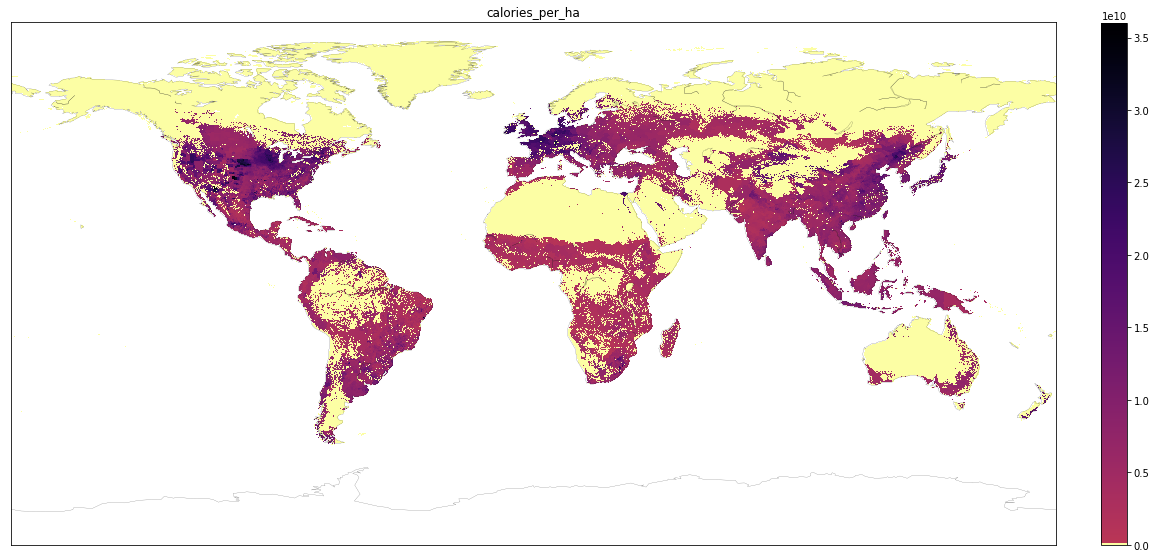

In [171]:
visualize_data(df,'calories_per_ha', colorscheme='sequential')

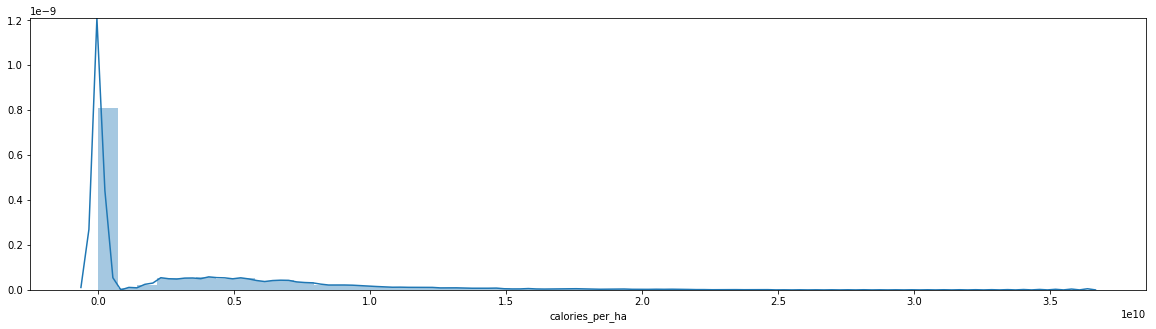

In [193]:
fig,ax = plt.subplots(figsize=(20,5))
sns.distplot(df['calories_per_ha'],ax=ax);

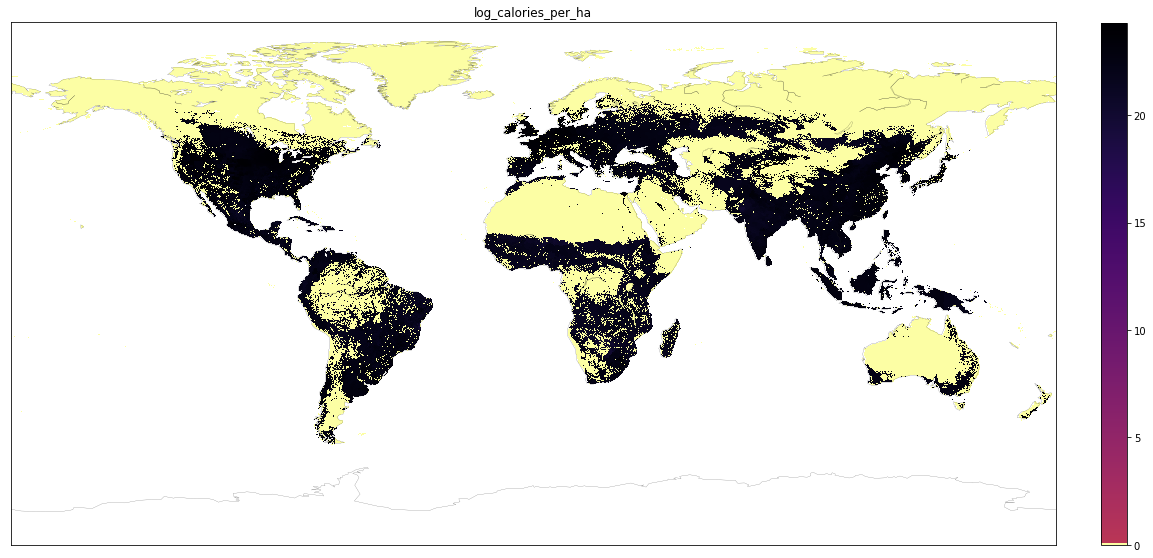

In [164]:
visualize_data(df,'log_calories_per_ha',
               colorscheme='sequential',resize=(0,1))

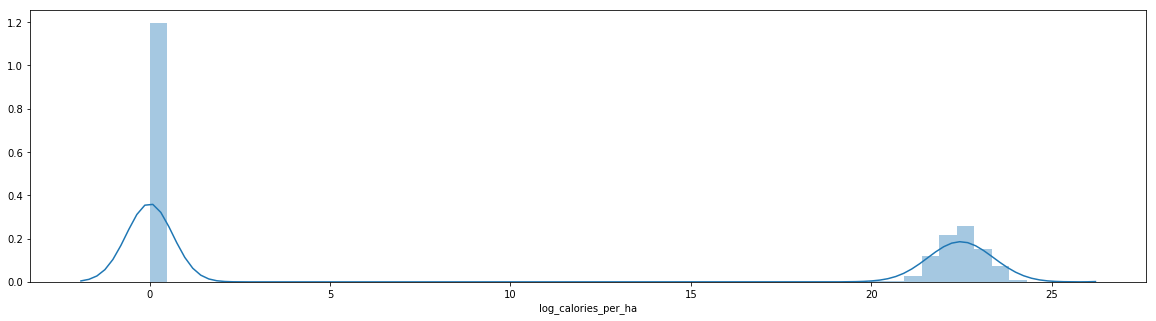

In [195]:
fig,ax = plt.subplots(figsize=(20,5))
sns.distplot(df['log_calories_per_ha'],ax=ax);

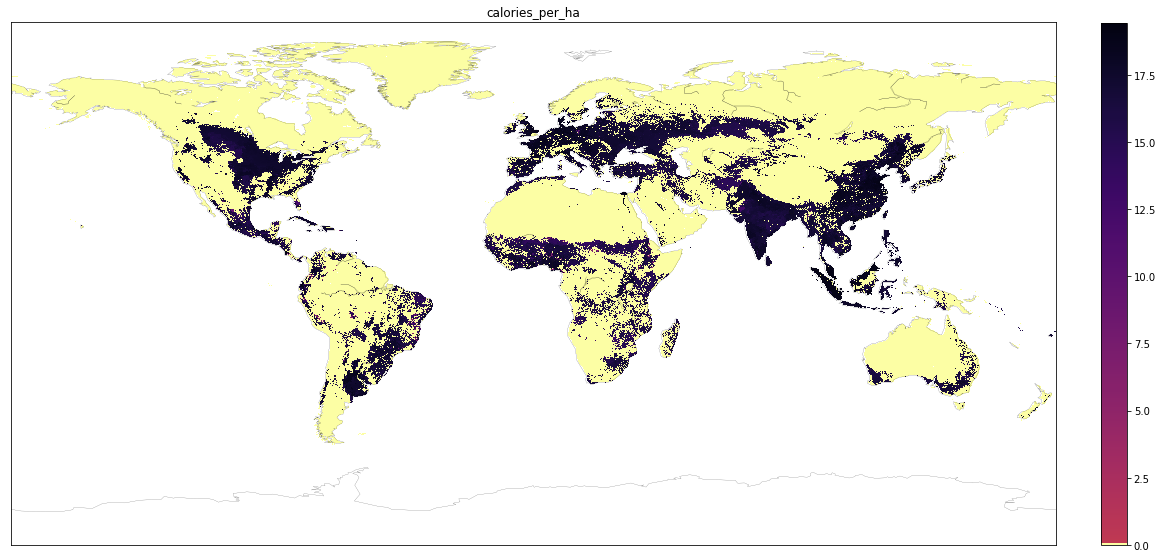

In [170]:
visualize_data(old_baseline_df,'calories_per_ha',
               colorscheme='sequential',resize=(0.0,.97))

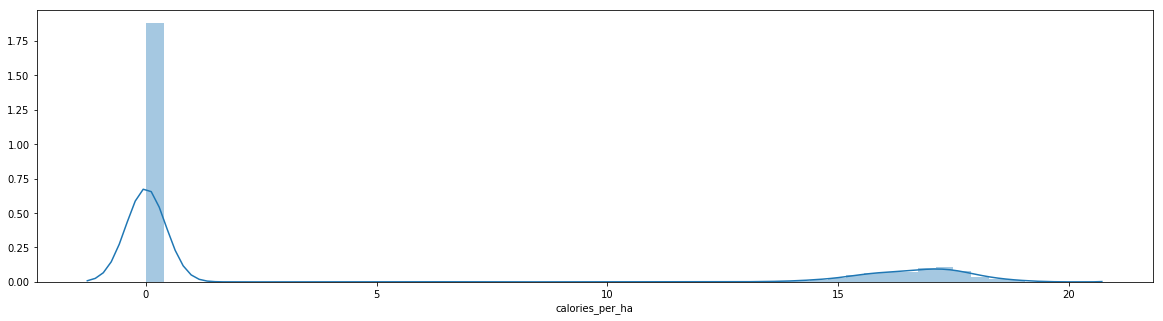

In [194]:
fig,ax = plt.subplots(figsize=(20,5))
sns.distplot(old_baseline_df['calories_per_ha'],ax=ax);

#### Bug to look into (todo)
Why Worldclim var wouldn't plot(Climate + Slope) ?

In [ ]:
for col in baseline_df.columns:
    visualize_data(baseline_df,col,colorscheme='sequential',title=col)

In [131]:
serie = baseline_df['Annual Precipitation']
serie.min()

-1.700000000000002e+308

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/image.py:408: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * 1.e7
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/image.py:413: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * 1.e7
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/image.py:450: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


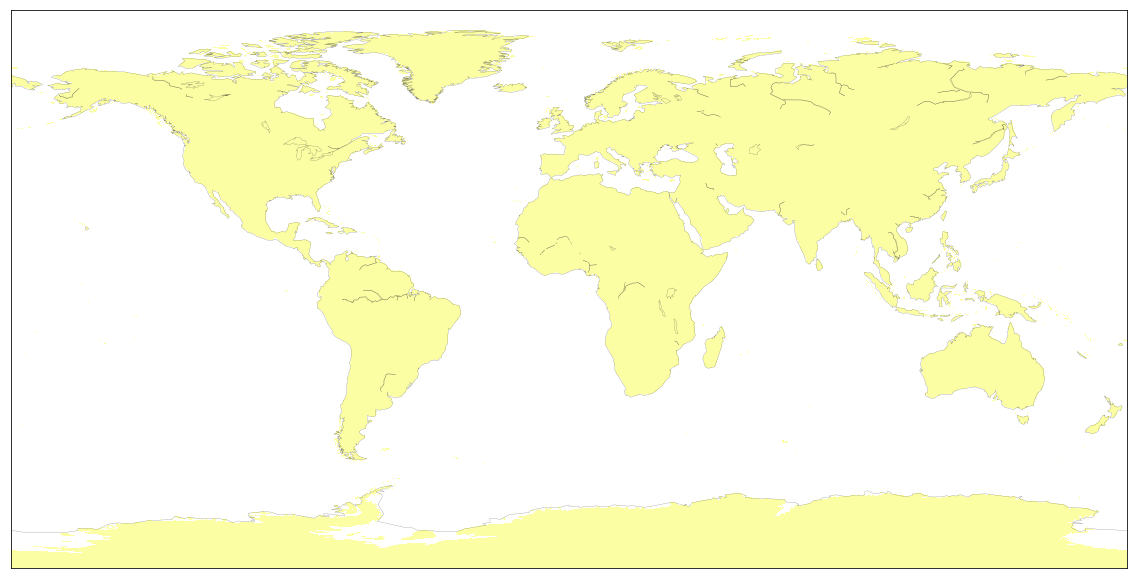

In [135]:
df=baseline_df
col_name='Annual Mean Temperature'
savefig=False
shape=(2160,4320)
title=None
resize=False
fig,axes = plt.subplots(1, 1, figsize=(20,15))
match_af = hb.ArrayFrame(match_raster)
zeros_array = np.zeros(match_af.size)
zeros_df = pd.DataFrame(zeros_array)
DF = df[col_name].reset_index()
### Merge with zeros_df to include non-ag pixels
full_df = pd.merge(zeros_df, DF, left_index=True, right_on='pixel_id', how='outer')
raw_cmap = plt.get_cmap('inferno_r') #alternatively 'magma'
cmap = customColorMap(raw_cmap, full_df[col_name],resize)


data = np.array(full_df[col_name])
bm = Basemap()
im = bm.imshow(np.flipud(data.reshape(shape)),cmap=cmap)
bm.drawcoastlines(linewidth=0.15, color='0.1')
 

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/colorbar.py:648: RuntimeWarning: overflow encountered in add
  + self._boundaries[1:])
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/ticker.py:1910: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/ticker.py:1933: RuntimeWarning: overflow encountered in double_scalars
  best_vmin = (_vmin // step) * step


ValueError: arange: cannot compute length

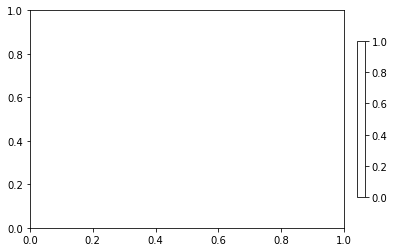

In [136]:
cbar = plt.colorbar(im, orientation='vertical',fraction=0.0234, pad=0.04)


gdp


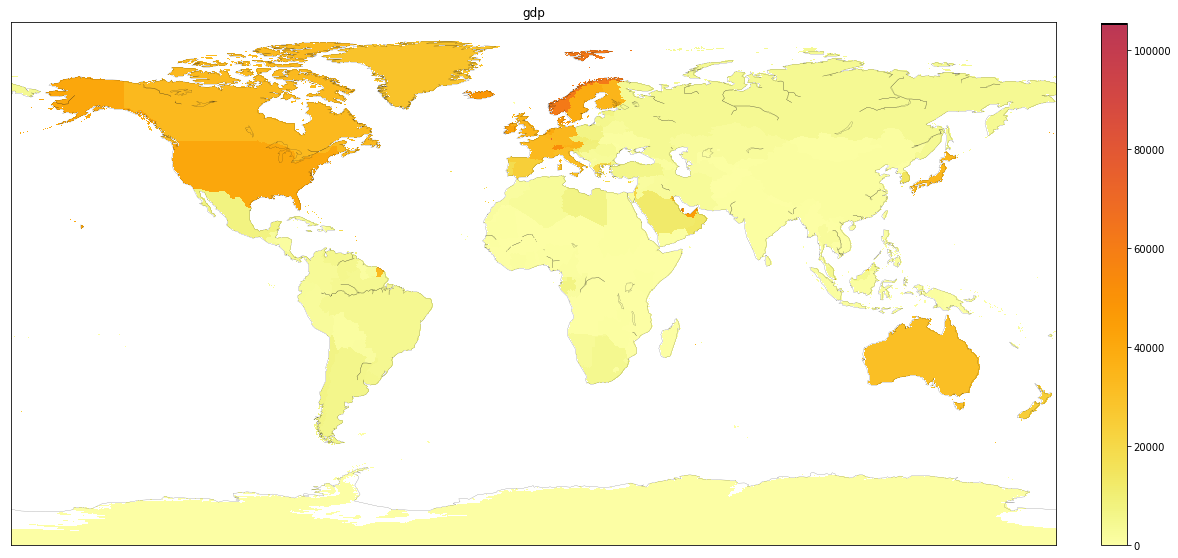

gdp_per_capita


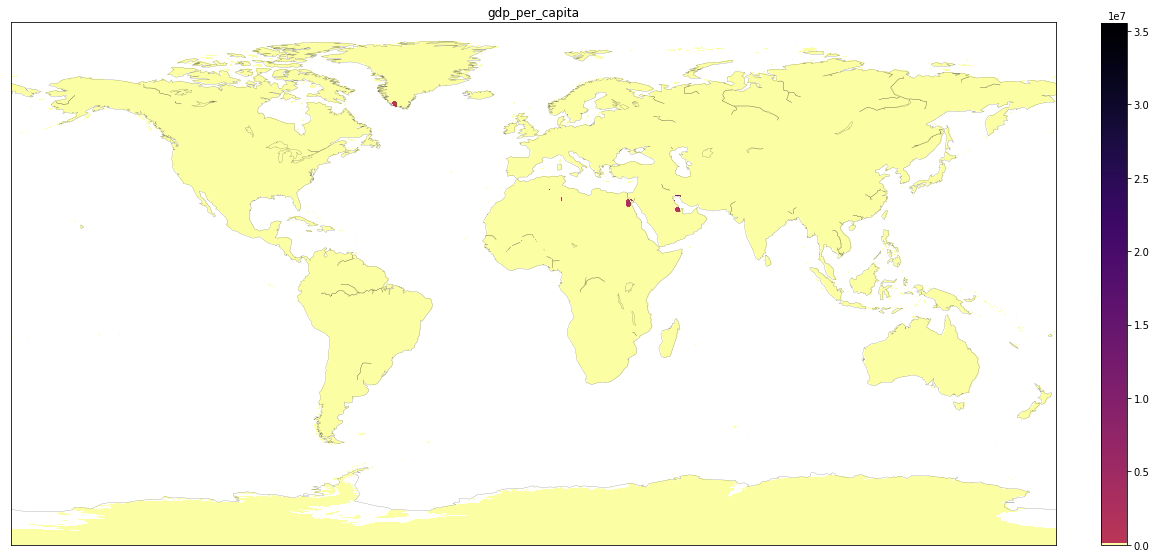

Annual Mean Temperature


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/colorbar.py:648: RuntimeWarning: overflow encountered in add
  + self._boundaries[1:])
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/ticker.py:1910: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/ticker.py:1933: RuntimeWarning: overflow encountered in double_scalars
  best_vmin = (_vmin // step) * step


ValueError: arange: cannot compute length

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/image.py:408: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * 1.e7
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/image.py:413: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * 1.e7
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/image.py:450: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)
/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


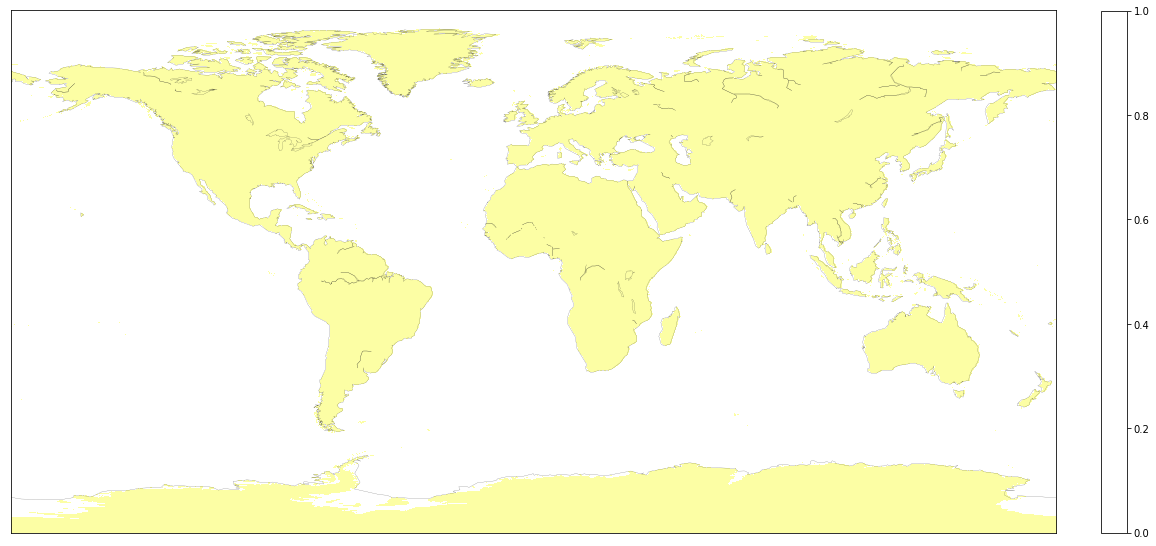

#### Make and save baseline_df

In [312]:
gdp = pd.read_csv('../Data/intermediate/Socioeco_csvs/GDP.csv')
gdp_p = pd.read_csv('../Data/intermediate/Socioeco_csvs/GDP_per_capita.csv')
mins = pd.read_csv('../Data/intermediate/Socioeco_csvs/minutes_to_market.csv')
soil = pd.read_csv('../Data/intermediate/Soil_csvs/2000.csv')
climate = pd.read_csv('../Data/intermediate/Climate_csvs/2000.csv')
lu = pd.read_csv('../Data/intermediate/LU_csvs/Cropmask_lulc_esa_2000.csv')
topography = pd.read_csv('../Data/intermediate/Soil_csvs/topography.csv')
crop = pd.read_csv('../Data/intermediate/Crop_csvs/Caloric_Yields.csv')


In [315]:
from functools import reduce
dfs = [crop,gdp,gdp_p, mins, climate, soil, topography]
df = reduce(lambda left,right: pd.merge(left,right,on='pixel_id',how='outer'), dfs)

In [316]:
df = df.set_index('pixel_id')

df = df.dropna(subset=['calories_per_ha'])

# Deal with NaNs
df['slope'] = df['slope'].replace({-9999: np.nan})  # 143 NaN in 'slope' variable
for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
    df[soil_var] = df[soil_var].replace({255: np.nan})
for clim_var in bioclim_var_names:
    df[clim_var] = df[clim_var].replace({-1.7e308: np.nan})    

        
#Transformations
df['slope'] = df['slope'].apply(lambda x:x-90)
for col in ['altitude', 'minutes_to_market']:
    df[str('log_'+col)] = df[col].apply(lambda x: np.log(x) if x != 0 else 0)
    df = df.drop(col,axis=1)
    
for col in ['calories_per_ha']:
    df[str('log_'+col)] = df[col].apply(lambda x: np.log(x) if x != 0 else 0)

In [317]:
# Cols to drop
for col in df.columns:
    if ('land_mask' in col) or ('Unnamed:' in col):
        df = df.drop(col,axis=1)

ValueError: labels ['Unnamed: 0_x'] not contained in axis

In [318]:
df = df.drop('Unnamed: 0',axis=1)

In [319]:
df.to_csv('../Data/intermediate/baseline_df.csv')

### Old baseline_df 

Sets of inputs: 

'slope', 'log_altitude',


log_gdp_per_capita', 'gdp','log_min_to_market',

'log_gpw_population'


'lon', 'lat',  'sin_lon', 

workability_index', 'toxicity_index', 'rooting_conditions_index','protected_areas_index','oxygen_availability_index','nutrient_retention_index', 'nutrient_availability_index',
       'excess_salts_index',

'temp_avg', 'temp_diurnalrange',
       'temp_isothermality', 'temp_seasonality', 'temp_annualmax',
       'temp_annualmin', 'temp_annualrange','precip', 'precip_wet_mth',
       'precip_dry_mth', 'precip_seasonality', 
       
Climate zones (as dummies)

#### Save full (with non ag in current pixels) baseline_df (do this once ever)
Because how about pixels that were not but become ag!?

In [223]:
###TODO load_new_data():

def load_baseline_df():
    crop_types_df = pd.read_csv('../../Food_ES/Crop modeling/ipbes_invest_crop_yield_project/intermediate/aggregate_crops_by_type/aggregated_crop_data.csv')
    df_land = pd.read_csv('../../Food_ES/Crop modeling/ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_regression_data.csv')
    df = crop_types_df.merge(df_land,how='outer',on='pixel_id')
    
    #Remove cal_per_ha per crop type for now
    df = df.drop(labels=['c3_annual_calories_per_ha', 'c3_perennial_calories_per_ha',
           'c4_annual_calories_per_ha', 'c4_perennial_calories_per_ha',
           'nitrogen_fixer_calories_per_ha'], axis=1)

    #Remove helper columns (not features)
    df = df.drop(labels=['Unnamed: 0'
                        # , 'country_ids','ha_per_cell_5m'
                        ], axis=1)
    
    return df

def data_preprocessing(df):    
    # Rename cols
    df = df.rename(columns={'minutes_to_market_5m': 'min_to_market',
                            'gdp_per_capita_2000_5m': 'gdp_per_capita',
                            'gdp_2000': 'gdp'})
    
    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
        
    # Drop NaN
    df = df.dropna()
    
    ## /!\ DO NOT DO THIS TO HAVE SLOPE ETC DATA FOR AREAS THAT MAY BECOME AG !
    ## df = df[df['calories_per_ha'] != 0]    
    ## 
    
    #Encode climate zones (as str)
    climate_zones_map = {1:'Af',2:'Am',3:'Aw',
                     5:'BWk',4:'BWh',7:'BSk',6:'BSh',
                     14:'Cfa',15:'Cfb',16:'Cfc',8:'Csa',
                     9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',13:'Cwc',
                     25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',17:'Dsa',18:'Dsb',19:'Dsc',
                     20:'Dsd',21:'Dwa',22:'Dwb',23:'Dwc',24:'Dwd',
                     30:'EF',29:'ET'}
    df['climate_zones'] = df['climate_zones'].map(climate_zones_map)
    
    # Encode climate zones as dummies
    climate_dummies_df = pd.get_dummies(df['climate_zones'])
    for col in climate_dummies_df.columns:
        climate_dummies_df = climate_dummies_df.rename({col:str('climatezone_'+col)},axis=1)
    
    df = df.merge(climate_dummies_df, right_index=True,left_index=True)
    df = df.drop('climate_zones',axis=1)
    
    # Lat/Lon
    df['sin_lon'] = df['lon'].apply(lambda x:np.sin(np.radians(x)))
    #df = df.drop('lon',axis=1)
    #df['sin_lat'] = df['lat'].apply(lambda x:np.sin(np.radians(x)))
    
    # Log some skewed variables
    df['calories_per_ha'] = df['calories_per_ha'].apply(lambda x: np.log(x) if x != 0 else 0)

    for col in ['gdp_per_capita','altitude', 'min_to_market', 'gpw_population']:
        df[str('log_'+col)] = df[col].apply(lambda x: np.log(x) if x != 0 else 0)
        df = df.drop(col,axis=1)
        
        
    # Slope
    df['slope'] = df['slope'].apply(lambda x:x-90)
                
    
    # Cols to drop
    for col in ['pixel_id_float', 'land_mask']:
        df = df.drop(col,axis=1)
    
    #Set index 'pixel_id'
    df = df.set_index('pixel_id')

    return df

In [224]:
baseline_df = data_preprocessing(load_baseline_df())

In [ ]:
len(baseline_df)

In [225]:
baseline_df.to_csv('../../Food_ES/Crop modeling/ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_df_full.csv')

#### Load Baseline df (for features not changing)

In [149]:
old_baseline_df = pd.read_csv('../../Food_ES/Crop modeling/ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_df_full.csv')
old_baseline_df = old_baseline_df.set_index('pixel_id')
#baseline_df_notchanging = baseline_df[['slope','log_altitude',
#                                      'workability_index']].copy()

In [ ]:
# for reference
simple_subset = ['slope','lat','sin_lon','log_altitude',
                  'workability_index',
                  'log_gpw_population',
                  'temp_avg','precip',
                  'calories_per_ha'] # calories_per_ha is actually log(calories_per_ha) !



## Train/test split on baseline df (save train/test separately)

# Check assumption that aggregating all crops is ok

Basically checking variability in response variable (= calories per ha for all crops aggregated), when all inputs very similar

In [205]:
df.head()

,calories_per_ha,gdp,gdp_per_capita,Annual Mean Temperature,Mean Diurnal Range,Isothermality,Temperature Seasonality,Max Temperature of Warmest Month,Min Temperature of Coldest Month,Temperature Annual Range,...,nutrient_retention_index,toxicity_index,excess_salts_index,rooting_conditions_index,Unnamed: 0,slope,land_mask,log_altitude,log_minutes_to_market,log_calories_per_ha
pixel_id,,,,,,,,,,,,,,,,,,,,,
330087,0.0,28962.040538,44718.297,0.000000,26.0,156.0,0.000000,0.000000,0.000000,40.175866,...,NaN,NaN,NaN,NaN,330087,-10089.0,1,3.610918,8.936693,0.0
330088,0.0,28962.040538,44718.297,1.885000,26.0,155.0,-1.600000,58.417741,0.285000,41.159672,...,NaN,NaN,NaN,NaN,330088,-10089.0,1,3.044522,8.932213,0.0
330089,0.0,28962.040538,44718.297,18.376667,26.0,155.0,-15.478333,574.380761,2.898333,41.159672,...,NaN,NaN,NaN,NaN,330089,-10089.0,1,2.302585,8.929435,0.0
334378,0.0,28962.040538,48977.184,37.643999,24.0,136.0,-31.733999,1155.119315,5.910000,43.913721,...,6.0,6.0,6.0,6.0,334378,-10089.0,1,0.000000,9.037296,0.0
334379,0.0,28962.040538,48977.184,37.210999,24.0,137.0,-31.379999,1146.762231,5.831000,42.954927,...,6.0,6.0,6.0,6.0,334379,-10089.0,1,1.791759,9.033723,0.0


In [204]:
for index, row in df.head().iterrows():
    print(row[2])


44718.297
44718.297
44718.297
48977.184
48977.184


In [230]:
def find_exact_clusters(df):
    result=pd.DataFrame(columns=['key','min','max','avg','ratio','size'])
    clusters = dict()   # Each entry is key => values = [list of log_ca for records with this key]
    
    for index, row in df.iterrows():
        log_ca = row[0]
        row2 = []
        for cell in row[1:]: 
            row2.append('{:.1f}'.format(cell))
        key = '_'.join(row2)
        if key not in clusters:
            clusters[key] = [log_ca]
        else:
            clusters[key].append(log_ca)
        
    sorted_by_value = sorted(clusters.items(), key=lambda kv: len(kv[1]), reverse=True)
    n = 0
    for kv in sorted_by_value:
        n += 1
        if n>1000: break
        key = kv[0]
        values = kv[1]
        vmin, vmax, vave = min(values), max(values), sum(values)/len(values)
        ratio = np.exp(vmax-vmin)
        if len(values)>1:
            result = result.append({'key':key,'min':min(values),'max':max(values),
                                 'avg':sum(values)/len(values),'ratio':ratio,'size': len(values)}, ignore_index=True)
        #print('{} \n\t min={:.3f} max={:.3f} ave={:.3f}, ratio={:.1f}, size={}\n'.format(
        #    key, min(values), max(values), sum(values)/len(values), ratio, len(values)))
    
    return (result)
find_exact_clusters(df.drop(['log_calories_per_ha'],axis=1).round(1))

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/pandas/core/series.py:1410: RuntimeWarning: overflow encountered in multiply
  result = _values_from_object(self).round(decimals)


,key,min,max,avg,ratio,size


In [ ]:
# First I had only clusters of size 1.


# Fit and save model(s)

In [245]:
inputs = [x for x in DF.columns if (x !='calories_per_ha' and x!='log_calories_per_ha')]

In [244]:
DF = baseline_df.copy()

In [ ]:
## Inputs : everything but fertilizers:
DF = baseline_df.copy()
inputs = [x for x in DF.columns if (x !='calories_per_ha' and x!='log_calories_per_ha')]

validation_R2 = pd.DataFrame(columns=['Model','Validation_R2','inputs'])


# # # - - - XGB - - - # # #
model = 'xgb3'
best_parameters3 = {'colsample_bytree': 0.85, 'learning_rate': 0.02, 'max_depth': 10,
 'min_child_weight': 3, 'n_estimators': 700, 'nthread': 4,
 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.85}
regression = xgb.XGBRegressor(**best_parameters3)

X_train = DF.drop(['calories_per_ha','log_calories_per_ha'], axis=1)
y_train = DF['log_calories_per_ha']
regression.fit(X_train, y_train)
save_model('../Data/intermediate/Models/'+model+'_all_but_fertl.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,
                                      'Validation_R2':R2_validation
                                     'inputs': inputs
                                     },ignore_index=True)

# # # - - - Linear - - - # # #

model = 'Linear'
regression = LinearRegression()

X_train = DF.drop(['calories_per_ha','log_calories_per_ha'], axis=1)
y_train = DF['log_calories_per_ha']
regression.fit(X_train, y_train)
save_model('../Data/intermediate/Models/'+model+'_all_but_fertl.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,
                                      'Validation_R2':R2_validation
                                     'inputs': inputs
                                     },ignore_index=True)

In [ ]:
# # # - - - Poly - - - # # #

model = 'Poly'
regression = LinearRegression()

df2 = make_polynomial(df_sub)

df_validation = X_validation.merge(pd.DataFrame(y_validation),right_index=True,left_index=True)
df_val_poly = make_polynomial(df_validation[simple_subset])
X_val2 = df_val_poly.drop(['calories_per_ha'], axis=1)

X_train = df2.drop(['calories_per_ha'], axis=1)
y_train = df2['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'_simplesubset.sav')
y_predicted = regression.predict(X_val2)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

validation_R2.to_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_simplesubset.csv')

In [ ]:
# # # - - - Lasso - - - # # #

model = 'Lasso'
best_params_Lasso = {'alpha': 0.001, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
regression = Lasso(**best_params_Lasso)

X_train = df_sub.drop(['calories_per_ha'], axis=1)
y_train = df_sub['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'_simplesubset.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Ridge - - - # # #

model = 'Ridge'
best_paramsR = {'alpha': 0.001, 'max_iter': 1000, 'tol': 1e-06}
regression = Ridge(**best_paramsR)

X_train = df_sub.drop(['calories_per_ha'], axis=1)
y_train = df_sub['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'simplesubset.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)


# Create future dfs + run model

### Utilities

In [33]:
def create_future_df(LU_df, climate_df,Pop_df):
    
    # Mask not-ag pixels
    future_df = (LU_df[LU_df['%cropland']!=0][['lon','lat','%cropland']]).merge(baseline_df_notchanging,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True)
    
    # Merge with climate columns
    future_df = future_df.merge(climate_df[['temp_avg','precip']],how='left',
                            left_index=True, right_index=True)
    
    future_df = future_df.merge(Pop_df,how='left',
                               left_index=True, right_index=True)
    
    future_df['sin_lon'] = future_df['lon'].apply(lambda x:np.sin(np.radians(x)))
    
    # Dumb column order needed by dumb XGB!
    future_df_formatted = future_df[['slope', 'lat', 'sin_lon','log_altitude','workability_index',
                                     'log_gpw_population', 'temp_avg', 'precip']]
    
    return future_df_formatted
    

In [28]:
def load_regression(model):
    model_filename = '../Data/inputs/Models/'+model+'.sav'
    regression = pickle.load(open(model_filename, 'rb'))
    return regression

In [29]:
def run_model_on_future_df(future_df):
    '''Runs XGB3 Simple Subset Model and add a column log(cal_per_ha)'''
    
    regression = load_regression('xgb3simplesubset')
    y_predicted = regression.predict(future_df)

    future_df['log(cal_per_ha)'] = y_predicted
   
    return future_df

In [71]:
def export_future_df(F,save_name=False):
    
    F = F.merge(baseline_df[['lon','ha_per_cell_5m','calories_per_ha']].rename({'calories_per_ha':'log(cal_per_ha) 2000'},axis=1),
                how='left',right_index=True,left_index=True)

    F = F.merge(LU_df[['%cropland','%cropland 2000']],
                how='left',right_index=True,left_index=True)    #check how:'outer' ?
    

    F['population'] = F['log_gpw_population'].apply(lambda x: np.exp(x))
    F['altitude'] = F['log_altitude'].apply(lambda x: np.exp(x))

    F['calories_per_ha'] = F['log(cal_per_ha)'].apply(lambda x: np.exp(x))
    F['calories_per_ha 2000'] = F['log(cal_per_ha) 2000'].apply(lambda x: np.exp(x))

    # Yields to production 
    F['Calories'] = F['calories_per_ha'] * F['ha_per_cell_5m'] * F['%cropland']
    F['Calories 2000'] = F['calories_per_ha 2000'] * F['ha_per_cell_5m'] * F['%cropland 2000']
    F['Change_in_Yield'] = F['calories_per_ha'] - F['calories_per_ha 2000']
    F['Change_in_Production'] = F['Calories'] - F['Calories 2000']
    
    
    Fmin = (F[['log(cal_per_ha)','calories_per_ha', 'Calories','%cropland',
              'Change_in_Yield','Change_in_Production',
              'log(cal_per_ha) 2000','calories_per_ha 2000','Calories 2000','%cropland 2000',
              'temp_avg', 'precip','workability_index','slope', 'altitude',
              'lat', 'lon', 'population','ha_per_cell_5m']]).round(
                  {'calories_per_ha': 0, 'Calories': 0, '%cropland': 0,
                   'calories_per_ha 2000': 0, 'Calories 2000': 0,'%cropland 2000': 0,
                   'altitude':0,'lon':6,'lat':6})
    
    if save_name != False:
        Fmin.to_csv('../Data/outputs/'+save_name+'.csv')
    
    return Fmin

### Loop over all scenarios

#### Oct29, Prelim results for students (17:04 - 

In [72]:
scenarios_dict = {'RCP2.6_SSP1':'26', 'RCP4.5_SSP2':'45','RCP7.0_SSP3':'60',
                 'RCP6.0_SSP4':'60','RCP8.5_SSP5':'85'}

LU_df_cur = pd.read_csv('../Data/intermediate/LU_csvs/Cropmask_lulc_esa_2015.csv')
LU_df_cur = LU_df_cur.set_index('pixel_id')
    
for climate_model in ['cc','he','mr','gs']:
    print('Climate model: '+climate_model)
    for scenario_key in scenarios_dict.keys():
        print(scenario_key[-4:])
        
        # Load LU_df + climate_df + Pop_df to create future_df
        print('... Loading climate, pop and LU csvs')
        
        #Old: to get LULC
        #LU_df_path = '../Data/intermediate/LU_csvs/lulc_'+scenario_key+'.csv'
        #LU_df = pd.read_csv(LU_df_path)
        #LU_df['cropland'] = LU_df['lulc'].apply(lambda lulc:(1 if lulc==2 else 0))
        #LU_df = LU_df.set_index('pixel_id')
        
        LU_df_path = '../Data/intermediate/LU_csvs/Cropmask_lulc_'+scenario_key+'.csv'
        LU_df = pd.read_csv(LU_df_path)
        LU_df = LU_df.set_index('pixel_id')
        
        LU_df = LU_df.merge(pd.DataFrame(LU_df_cur['%cropland']).rename({'%cropland':'%cropland 2000'},axis=1),
                            how='outer',right_index=True,left_index=True)
       
        climate_df_path = '../Data/intermediate/Climate_csvs/'+climate_model+scenarios_dict[scenario_key]+'bi50.csv'
        climate_df = pd.read_csv(climate_df_path)
        climate_df = climate_df.set_index('pixel_id')
        
        Pop_df_path = '../Data/intermediate/Population_csvs/'+scenario_key[-4:]+'_geotiff_tot_5m.csv'
        Pop_df = pd.read_csv(Pop_df_path)
        Pop_df['log_gpw_population'] = Pop_df['gpw_population'].apply(lambda x:np.log(x) if x!=0 else 0)
        Pop_df = Pop_df[['pixel_id','log_gpw_population']].set_index('pixel_id')

        future_df = create_future_df(LU_df, climate_df, Pop_df)
        
        # Run model
        print('... Run model')
        future_df = run_model_on_future_df(future_df)
        
        #Save results
        print('... Saving results')
        final_df = export_future_df(future_df,
                                    save_name='Prelim_results_for_students/'+scenario_key[-4:]+'_'+climate_model)

        #Viz
        #visualize_data(final_df,'Change_in_Production',colorscheme = 'diverging')
        

Climate model: cc
SSP1
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP2
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP3
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP4
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP5
... Loading climate, pop and LU csvs
... Run model
... Saving results
Climate model: he
SSP1
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP2
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP3
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP4
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP5
... Loading climate, pop and LU csvs
... Run model
... Saving results
Climate model: mr
SSP1
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP2
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP3
... Loading climate, pop and LU csvs
... 

FileNotFoundError: File b'../Data/intermediate/Climate_csvs/gs26bi50.csv' does not exist

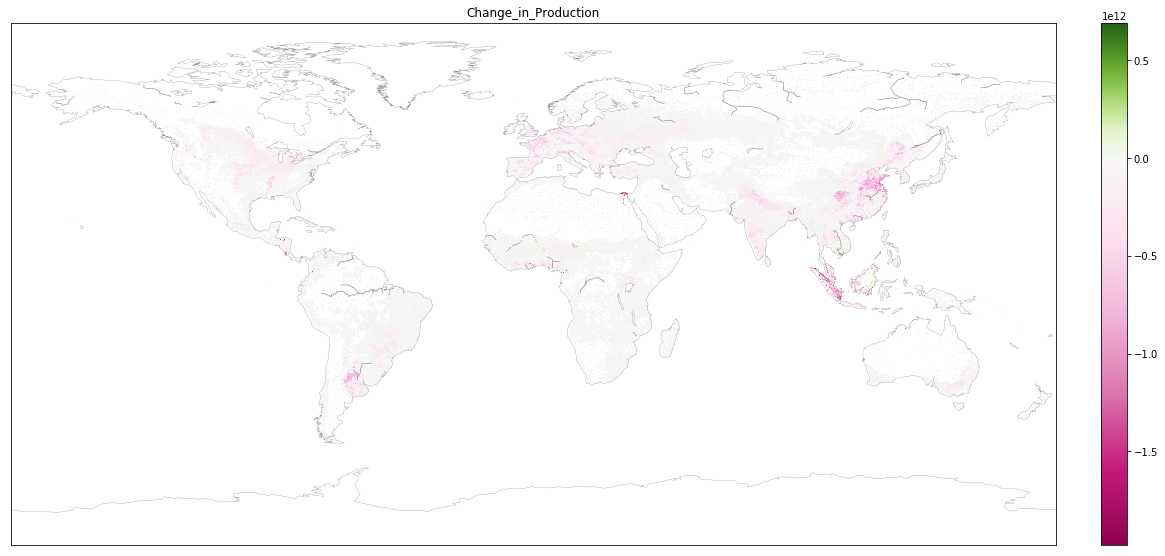

In [50]:
visualize_data(expo,'Change_in_Production',colorscheme = 'diverging')

# Visualization functions

In [93]:
## Geographical visualization function
def visualize_data(df,col_name,savefig=False,colorscheme='diverging',
                   shape=(2160,4320),title=None,resize=False):

    
    fig,axes = plt.subplots(1, 1, figsize=(20,15))

    # -- Prepare data --
    #Make a zeros_df of length 9331200
    match_af = hb.ArrayFrame(match_raster)
    zeros_array = np.zeros(match_af.size)
    zeros_df = pd.DataFrame(zeros_array)
    DF = df[col_name].reset_index()
    ### Merge with zeros_df to include non-ag pixels
    full_df = pd.merge(zeros_df, DF, left_index=True, right_on='pixel_id', how='outer')
    
    ## -- Plot column --
    
    #Colorscale
    if colorscheme == 'diverging':
        raw_cmap =  plt.get_cmap('PiYG')
        cmap = customColorMap(raw_cmap, full_df[col_name],resize)
    elif colorscheme == 'sequential':
        raw_cmap = plt.get_cmap('inferno_r') #alternatively 'magma'
        cmap = customColorMap(raw_cmap, full_df[col_name],resize)
    #else:
        #cmap = replicateColorMap(colorscheme,vmin=14.022869333967861,vmax=19.24083736317894)
        
    
    
    
    #Plot data
    data = np.array(full_df[col_name])
    bm = Basemap()
    im = bm.imshow(np.flipud(data.reshape(shape)),cmap=cmap)
    bm.drawcoastlines(linewidth=0.15, color='0.1')
    
    cbar = plt.colorbar(im, orientation='vertical',fraction=0.0234, pad=0.04)
    
    if title == None:
        plt.title(col_name)
    else:
        plt.title(title)
    plt.show()
  
    if savefig != False:
        fig.savefig(savefig)
        
   #if colorscheme != cmap:    
   #     return cmap

def customColorMap(cmap, serie, resize=False, name='blabla'):
    '''Charlie's function to re-center and re-size colormap'''
    
    vmax = serie.max()
    vmin = serie.min()
    midpoint= 1 - vmax / (vmax + abs(vmin))
    #print(vmin,vmax,midpoint)
    
    
    if resize!=False: 
        start=resize[0]
        stop =resize[1]
        ### Could do directly with quantiles e.g  start = 1 / (serie.quantile(0.1) / serie.min() )
        ### And stop =  1 / (serie.quantile(0.9) / serie.max() )
    else:
        start = 0
        stop  = 1
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [92]:
# Visualize input raster ??

def plot_col(df, col_name, shape=(2160, 4320)):
    m = np.array(df[col_name])
    bm = Basemap()
    im = bm.imshow(np.flipud(m.reshape(shape)))
    bm.drawcoastlines(linewidth=0.15, color='0.1')
    cbar = plt.colorbar(im, orientation='horizontal')
    plt.title(col_name)
    plt.show()

# Various: nc files, reclassify

In [ ]:
# To extract NC files, use this HB funciton:
hb.extract_luh_netcdf_to_geotiffs(states_path, output_dir, year - 2015)  # 0 = 2015, last year is 85=2100

In [ ]:
# Here's the recategorization i used,  notated as [ESA class] = [SEALS output class, 'esa description', 'seals description']:

p.esacci_to_seals_simplified_correspondence = OrderedDict()
p.esacci_to_seals_simplified_correspondence[0] = [0, 'ndv', 'ndv']
p.esacci_to_seals_simplified_correspondence[10] = [2, 'crop_rainfed', 'crop']
p.esacci_to_seals_simplified_correspondence[11] = [2, 'crop_rainfed_herb', 'crop']
p.esacci_to_seals_simplified_correspondence[12] = [2, 'crop_rainfed_tree', 'crop']
p.esacci_to_seals_simplified_correspondence[20] = [2, 'crop_irrigated', 'crop']
p.esacci_to_seals_simplified_correspondence[30] = [2, 'crop_natural_mosaic', 'crop']
p.esacci_to_seals_simplified_correspondence[40] = [2, 'natural_crop_mosaic', 'crop']
p.esacci_to_seals_simplified_correspondence[50] = [4, 'tree_broadleaved_evergreen', 'forest']
p.esacci_to_seals_simplified_correspondence[60] = [4, 'tree_broadleaved_deciduous_closed_to_open_15', 'forest']
p.esacci_to_seals_simplified_correspondence[61] = [4, 'tree_broadleaved_deciduous_closed_40', 'forest']
p.esacci_to_seals_simplified_correspondence[62] = [4, 'tree_broadleaved_deciduous_open_15_40', 'forest']
p.esacci_to_seals_simplified_correspondence[70] = [4, 'tree_needleleaved_deciduous_closed_to_open_15', 'forest']
p.esacci_to_seals_simplified_correspondence[71] = [4, 'tree_needleleaved_evergreen_closed_to_open_15_extended', 'forest']
p.esacci_to_seals_simplified_correspondence[72] = [4, 'tree_needleleaved_evergreen_open_15_40', 'forest']
p.esacci_to_seals_simplified_correspondence[80] = [4, 'tree_needleleaved_deciduous_closed_to_open_15', 'forest']
p.esacci_to_seals_simplified_correspondence[81] = [4, 'tree_needleleaved_deciduous_closed_40', 'forest']
p.esacci_to_seals_simplified_correspondence[82] = [4, 'tree_needleleaved_deciduous_open_15_40', 'forest']
p.esacci_to_seals_simplified_correspondence[90] = [4, 'tree_mixed_type', 'forest']
p.esacci_to_seals_simplified_correspondence[100] = [4, 'mosaic_tree_and_shrub_50_herbaceous_cover_50', 'forest']
p.esacci_to_seals_simplified_correspondence[110] = [5, 'mosaic_herbaceous_cover_50_tree_and_shrub_50', 'shrubland']
p.esacci_to_seals_simplified_correspondence[120] = [5, 'shrubland', 'shrubland']
p.esacci_to_seals_simplified_correspondence[121] = [5, 'evergreen_shrubland', 'shrubland']
p.esacci_to_seals_simplified_correspondence[122] = [5, 'deciduous_shrubland_', 'shrubland']
p.esacci_to_seals_simplified_correspondence[130] = [3, 'grassland', 'grassland']
p.esacci_to_seals_simplified_correspondence[140] = [5, 'lichens_and_mosses', 'shrubland']
p.esacci_to_seals_simplified_correspondence[150] = [5, 'sparse_vegetation_tree_shrub_herbaceous_cover_15', 'shrubland']
p.esacci_to_seals_simplified_correspondence[151] = [4, 'sparse_tree_15', 'forest']
p.esacci_to_seals_simplified_correspondence[152] = [5, 'sparse_shrub_15', 'shrubland']
p.esacci_to_seals_simplified_correspondence[153] = [5, 'sparse_herbaceous_cover_15', 'shrubland']
p.esacci_to_seals_simplified_correspondence[160] = [4, 'tree_cover_flooded_fresh_or_brakish_water', 'forest']
p.esacci_to_seals_simplified_correspondence[170] = [4, 'tree_cover_flooded_saline_water', 'forest']
p.esacci_to_seals_simplified_correspondence[180] = [5, 'shrub_or_herbaceous_cover_flooded_fresh_saline_brakish_water', 'shrubland']
p.esacci_to_seals_simplified_correspondence[190] = [1, 'urban_areas', 'urban']
p.esacci_to_seals_simplified_correspondence[200] = [7, 'bare_areas', 'other']
p.esacci_to_seals_simplified_correspondence[201] = [7, 'consolidated_bare_areas', 'other']
p.esacci_to_seals_simplified_correspondence[202] = [7, 'unconsolidated_bare_areas', 'other']
p.esacci_to_seals_simplified_correspondence[210] = [6, 'water_bodies', 'water']
p.esacci_to_seals_simplified_correspondence[220] = [7, 'permanent_snow_and_ice', 'other']